/home/lambda/source/scarlet/flandre/.venv/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


2974


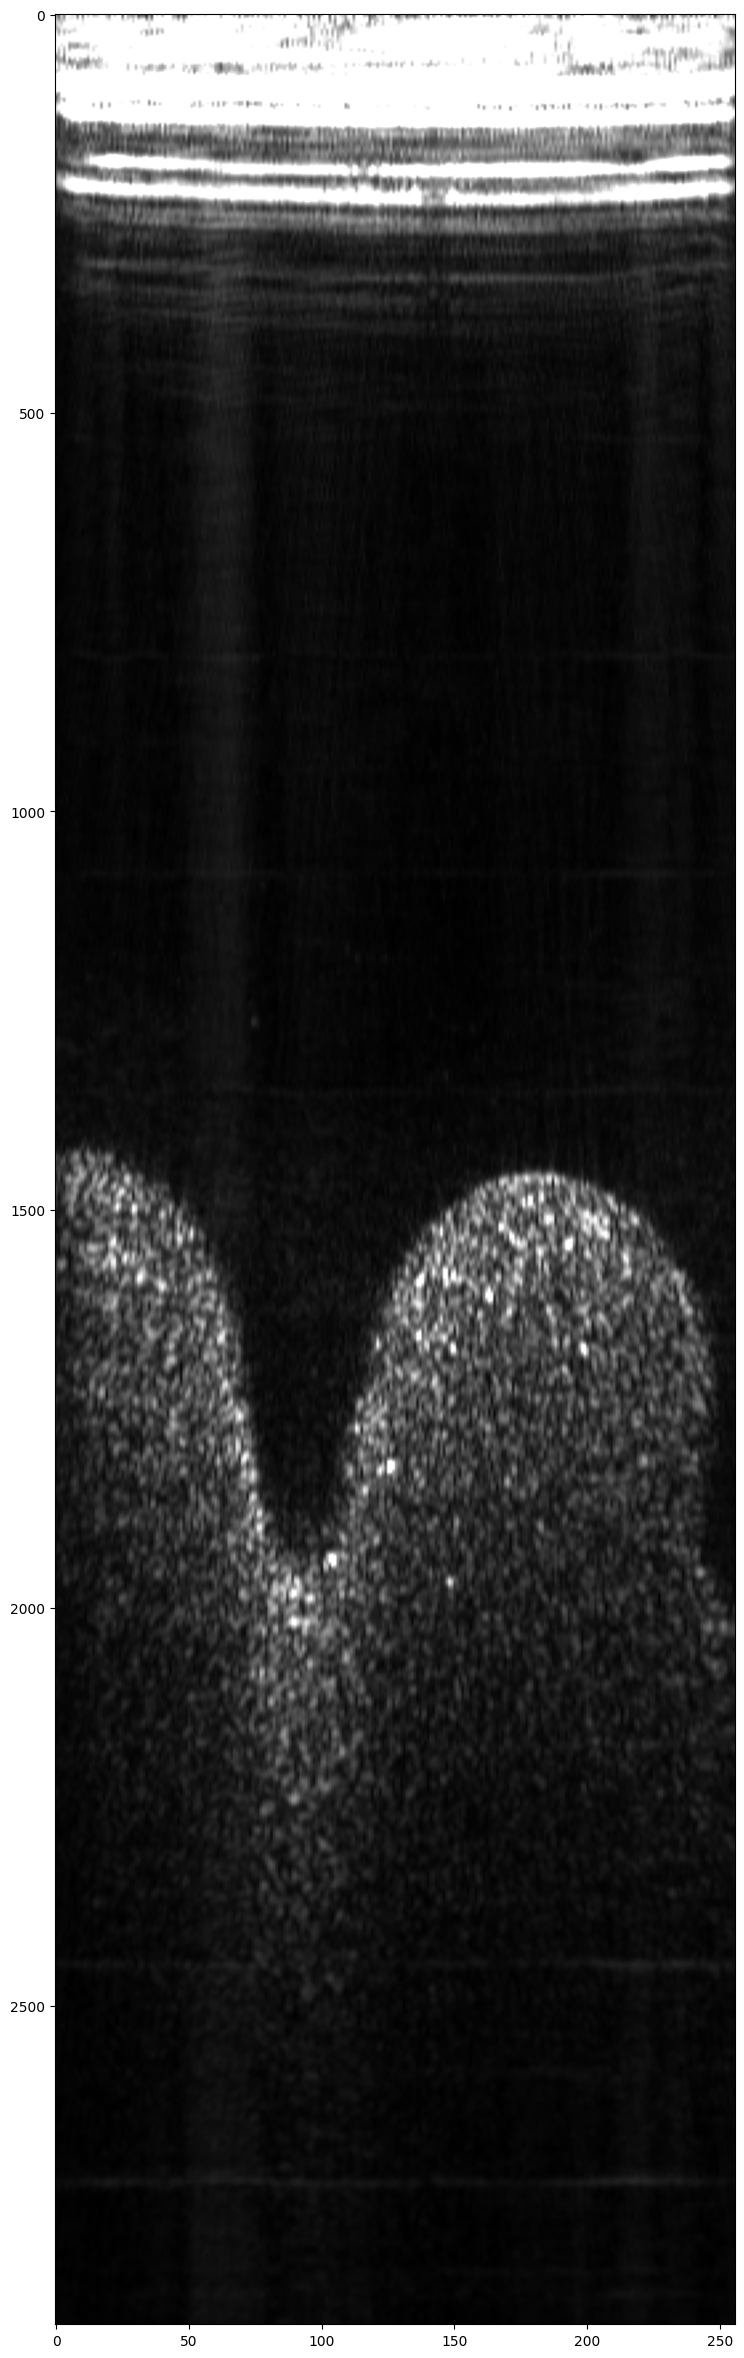

In [1]:
from matplotlib import pyplot as plt
from flandre.utils.RfMat import RfMat
import cupy as cp

from flandre.beamformer.das import gen_pwi
from flandre.beamformer.dist import direct_dist
from flandre.utils.Config import DeviceConfig
from flandre.utils.Msg import ImageArgMsg
from flandre.utils.RfSequence import RfSequence

arg = ImageArgMsg(
    sender='',
    t_end=2900,
    t_start=0,
    v2=1524,
    dct_center=1086,
    dct_bandwidth=915,
    f_rows=6002,
    beta=40,
    tgc=0,
    g8=80
)
rff = RfSequence('/run/media/lambda/b86dccdc-f134-464b-a310-6575ee9ae85c/us/baby789,S=(256 6002),M=PWI,U=120')

dc = DeviceConfig(v2=1540, rows=5999)
pwi, _, la = gen_pwi(direct_dist(dc, p=cp), dc)
print(la)

data = RfMat.from_rf_frame(rff.frames[1000], device='gpu')
data = data.dct_center(arg.dct_center, arg.dct_bandwidth)
data = data.call(lambda m: m.astype(cp.int16))
data = data.call(pwi)
data = data.call(cp.asarray, order='C')
data = data.argrelextrema()
data = data.conv_guass(b=arg.beta * 0.01)
data = data.crop(arg.t_start, arg.t_end)
data = data.time_gain_compensation_global((1 - arg.g8 * (1.0 / 128)) ** 2)
data = data.rotate90()

data.png('/home/lambda/source/scarlet/flandre/@DS/test.png', pre=300)

data.cpu().jupyter(figsize=(30, 30), aspect=0.3)
